# Monet Style Transfer

The purpose of this project is to build and train a model that will transform images to look like they were painted by Monet. The type of model will be a GAN - Generative Adversarial Network. This is a unique system that consists of two machine learning models - a generator and a discriminator. In my case, the generator will try to make images that look like Monet paintings. The discriminator will compare my generated images to real paintings and see if it can tell the difference. Its feedback will be used to update the generator model.

My project will use the kaggle competition dataset found [here](https://www.kaggle.com/competitions/gan-getting-started). The competition provides a large dataset with many parts. There are 300 Monet paintings of size 256 x 256 pixels in jpg and tfrecord formats. There are 7,028 photos of size 256 x 256 pixels in jpg and tfrecord formats as well. The goal will be to make the photos look more like Monet paintings.

Although the link in the competition details helped me get an idea of what I will be doing, I relied heavily upon [this](https://www.geeksforgeeks.org/deep-convolutional-gan-with-keras/) source to build my GAN. I give them credit for the architecture and training of my models.

In [1]:
import cv2
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras import layers

## EDA

There is not much data preprocessing required for this project. As stated above, the images are already available as tfrecord files. Seeing as I am not very comfortable working with tfrecord files, I will try to get the jpg files to work for now. In future projects, I would like to become proficient with tfrecords.

For fun, I will show a few example images from both datasets: the Monet paintings and the photos. At the end, we will hopefully see the photos looking more like the paintings!

In [9]:
#define base path
base_monet = '/kaggle/input/gan-getting-started/monet_jpg'
#read in files
monet_files = os.listdir(base_monet)
monet_paths = []
#create complete paths
for file in monet_files:
    monet_paths.append(base_monet + '/' + file)
len(monet_paths)

300

In [10]:
#same workflow for photos
base_photos = '/kaggle/input/gan-getting-started/photo_jpg'
base_files = os.listdir(base_photos)
photo_paths = []
for file in base_files:
    photo_paths.append(base_photos + '/' + file)
len(photo_paths)    

7038

<Figure size 1200x700 with 0 Axes>

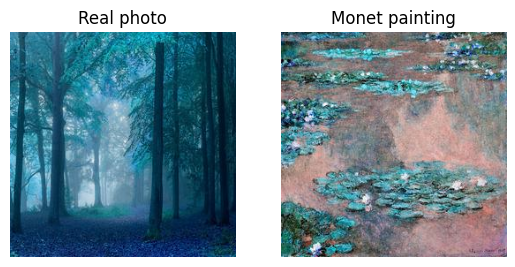

In [25]:
#create a figure and plot two examples side by side
plt.figure(figsize=(12,7))
#this bit of code removes a warning about overlapping axes
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#subplot one
plt.subplot(121)
plt.axis('off')
plt.imshow(cv2.imread(photo_paths[0]))
plt.title('Real photo')
#subplot 2
plt.subplot(122)
plt.axis('off')
plt.imshow(cv2.imread(monet_paths[0]))
plt.title('Monet painting')
plt.show()

As you can see, it may be a bit difficult to differentiate the two. I hope my discriminator model is at the top of its game.

## Data preprocessing

Now that I have the filepaths, I will go through and fill two numpy arrays with the monet paintings and photos, respectively. I will initialize some numpy arrays of known size and fill them with the information. I will keep my images with three channels (RGB) so the style transfer is more fun and obvious.

Note: you will see that I scale my pixel values the same as the [CycleGAN tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial). I scale them to a range of -1 to 1. This is because I will be using the tanh activation function to generate my images, which returns values from -1 to 1. This means that my real images and my generated ones will have the same range of pixel values. This should ensure my discriminator runs smoothly.

In [31]:
#initialize empty array and fill
monet_np = np.empty((300, 256, 256, 3))
for i, path in enumerate(monet_paths):
    img = cv2.imread(path)
    #scaling from -1 to 1
    scaled = img / 127.5 - 1
    monet_np[i] = scaled
monet_np[0].shape    

(256, 256, 3)

In [32]:
#same process
photo_np = np.empty((7038, 256, 256, 3))
for i, path in enumerate(photo_paths):
    if i % 1_000 == 0:
        print(f'{i} images processed.')
    img = cv2.imread(path)
    #scaling from -1 to 1
    scaled = img / 127.5 - 1
    photo_np[i] = scaled
photo_np[0].shape    

0 images processed.
1000 images processed.
2000 images processed.
3000 images processed.
4000 images processed.
5000 images processed.
6000 images processed.
7000 images processed.


(256, 256, 3)

Cool. Everything is prepared for the next step.

## Model architecture

As mentioned above, the model architecture resembles what I found in [this](https://www.geeksforgeeks.org/deep-convolutional-gan-with-keras/) article. In the article, it shows how the generator must upsample from random noise to the shape of the images (256 x 256 x 3). At the same time, my discriminator must accept examples of the same shape and predict whether or not they are real. I will modify the model slightly to begin with an image the same size as the output.

Generator - My generator will be a sequential model that accepts a certain amount of noise (a vector of small, randomized numbers generated by numpy). It will continue to upsample (make the image larger) the noise until it achieves the shape of my other images. It will achieve this using the Conv2DTranspose layer from keras. I will also include a number of batch normalization layers after each activation. Batch normalization assists back propagation and lessens the diminishing gradients problem commonly faced by neural networks. It ensures no values get too big or too small.

In [119]:
#shape of original images
img_shape = (256, 256, 3)

gen = keras.models.Sequential([
    #part of the model that breaks down the image
    layers.Input(img_shape),
    layers.Conv2D(16, (5, 5), (2, 2), padding='same', activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (5, 5), (2, 2), padding='same', activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (5, 5), (2, 2), padding='same', activation='leaky_relu'),
    layers.BatchNormalization(),
    #part of the model that builds up the image
    layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(32, (5, 5), (2, 2), padding='same', activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(16, (5, 5), (2, 2), padding='same', activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2DTranspose(3, (5, 5), (2, 2), padding='same', activation='tanh'),
])

gen.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 128, 128, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 32, 32, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 64, 64, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 128, 128, 16)        │          12,816 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 256, 256, 3)         │           1,203 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,923 (913.76 KB)

 Trainable params: 233,475 (912.01 KB)

 Non-trainable params: 448 (1.75 KB)

Now that we have a generator for our images, it's time to create the discriminator. From the previous project in the course, I made a decent model using the suggested sequential architecture - [Conv -> Conv -> Max Pooling]. I will recreate this model to classify the images as real monet paintings or fake ones made by me. I will be sure to include batch normalization layers to speed up the training process. My architecture aggressively reduces the size of the image early. In later convolutional stages, it has more channels and does not decrease the size of the image as significantly. I am hoping this allows my model to pick up on the differences between real and fake images.

In [120]:
dis = keras.models.Sequential([
    layers.Input([256, 256, 3]),
    layers.Conv2D(32, (5, 5), (2, 2), padding='same', activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (5, 5), (2, 2), padding='same', activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (5, 5), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (5, 5), activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

dis.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 28, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 24, 24, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,116,865 (4.26 MB)

 Trainable params: 1,115,905 (4.26 MB)

 Non-trainable params: 960 (3.75 KB)

## Model training

This portion of my project relies on the [same article](https://www.geeksforgeeks.org/deep-convolutional-gan-with-keras/) mentioned above. I need to compile my models and store them as part of a larger sequential model object - gan.

In [121]:
#compile discriminator model - binary classification problem
dis.compile(loss='binary_crossentropy', optimizer='adam')
#make it not trainable initially (useful later)
dis.trainable = False
#combine two models into single gan
gan = keras.models.Sequential([
    gen,
    dis,
])
#compile gan for binary classification problem
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 256, 256, 3)         │         233,923 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 1)                   │       1,116,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,350,788 (5.15 MB)

 Trainable params: 233,475 (912.01 KB)

 Non-trainable params: 1,117,313 (4.26 MB)

As you can see in my model summary, the first part of the gan outputs an image of shape 256 x 256 x 3. This is perfect for the discriminator, which takes in images of that size and outputs a prediction - whether or not the image is a painting by Monet. I will now train my gan over a series of epochs manually. We need to loop manually through each epoch because the generator needs to create a new batch of images, hopefully resembling Monet's paintings more closely than the previous epoch. The general loop is as follows:
- Generate Monet-style images from batch of photos
- Train discriminator: generated images are false, monet paintings are true
- Freeze discriminator weights: focused on training the generator portion of the gan
- Train the gan: pretend the generated images are real Monet paintings

In [166]:
#separate layers to call them individually
gen, dis = gan.layers

for epoch in range(5):
    print(f'Epoch {epoch+1} commencing.')
    idx = epoch*600
    X = np.empty((900, 256, 256, 3))
    preds = gen.predict(photo_np[idx:idx+600])
    X[:600] = preds
    X[600:] = monet_np
    y = np.empty(900)
    y[:600] = 0
    y[600:] = 1
    #training the discriminator with real and fake images
    dis.trainable = True
    dis.fit(X, y, batch_size=32)
    #training the gan with real monet images
    dis.trainable = False
    gan.fit(X[600:], y[600:], batch_size=32)

Epoch 1 commencing.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1327
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0000e+00
Epoch 2 commencing.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3358
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0000e+00
Epoch 3 commencing.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.4654
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0000e+00
Epoch 4 commencing.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2004
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0000e+00
Epoch 5 commencing.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.5285
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0000e+00


In [167]:
ten_tests = ((gen.predict(photo_np[:10]) + 1) * 127.5).astype('int')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


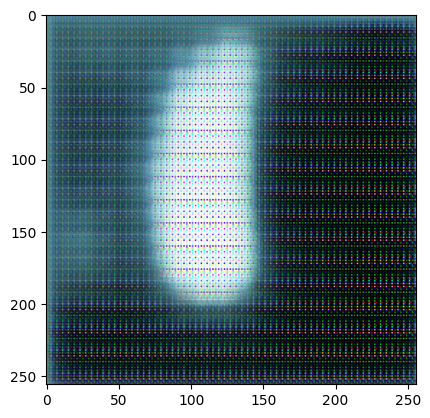

In [195]:
plt.imshow(ten_tests[0])

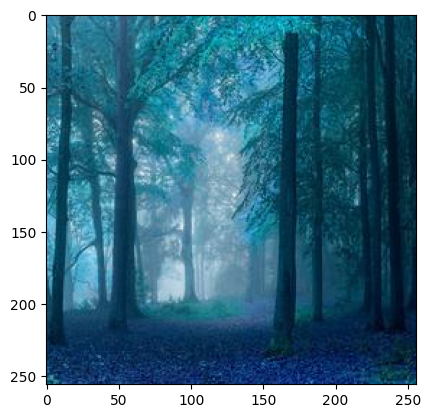

In [196]:
plt.imshow(cv2.imread(photo_paths[0]))

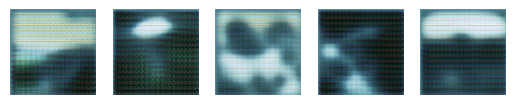

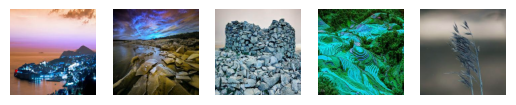

In [194]:
plt.subplots(1, 5, sharex=True, sharey=True)
#loop to make plot
for i in range(1,6):
    plt.subplot(1, 5, i)
    plt.imshow(ten_tests[i])
    plt.axis('off')

plt.subplots(1, 5, sharex=True, sharey=True)
for i in range(1,6):
    plt.subplot(1, 5, i)
    plt.imshow(cv2.imread(photo_paths[i]))
    plt.axis('off')

## Results and analysis

As you can see, my model is.. struggling a bit. It lacks a significant amount of nuance to it. This does, however, represent the best iteration of model I was able to generate. I tried many different things: changing to what portion of the data the gan was fit in the training cycle, changing how much of the data was included in each training cycle, changing how many epochs to train my models, shrinking the batch size to update the weights more frequently, and changing the architecture of my discriminator. I ended up making the discriminator more shallow (less trainable parameters) to try and give my generator a better shot at fooling it. Unfortunately, none of these techniques gave a definitively better result. All in all, my models struggled to produce a viable result that does not resemble anything like a Monet painting. I am, however, glad I tried to pioneer my own architecture as the synthesis of a couple different sources.

## Conclusion

In conclusion, I was unable to produce a model that can style transfer images to look like Monet paintings. The point of failure is my lack of understanding of how a gan works and my stubbornness to not rely more heavily on example notebooks. I was never sure what I was supposed to feed to my gan as the second part of each epoch - the examples of the Monet paintings or my own generated images that are supposed to look like Monet paintings. I refused to submit predictions to kaggle out of my shame.

For the future, I would look through more gan examples to build a better network. I would make sure I was manipulating the images correctly to produce a good output. I would experiment with making deeper/more shallow models to see if that affects the outcome. Both of my models are pretty deep - this may be contributing to the model's failure to converge on anything meaningful. I would also mess with the stride and padding elements of my models. From the results, you can clearly see the pixelation of my images by the stride in the upsampling. I would try reducing that to get a smoother image. When the images look smaller, they look better. And if I squint enough, they go away entirely.